In [1]:
import sys
sys.path.append("..//")

from AQUA_general import AQUA
from batchAQUA_general import batchAQUA
from stimulus import *
from plotting_functions import *

#from AQUAmeetBrian import AQUAMeetBrian


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from brian2 import *

WARNING    'C' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 100. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'a' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 0.03. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'b' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value -2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'e_a' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 0.2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'k' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 0.7. The internal variable will be 

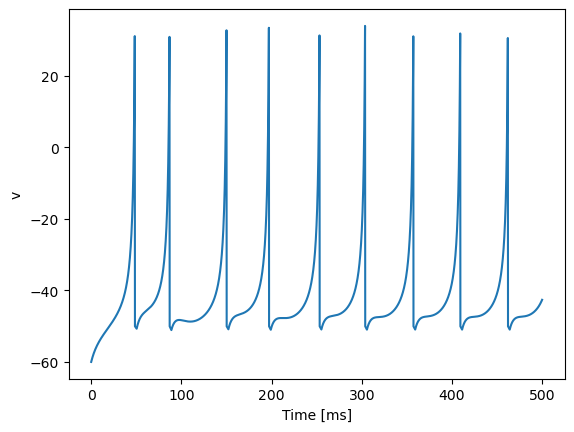

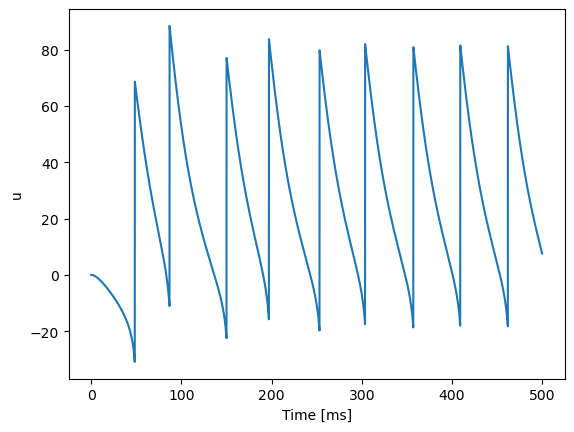

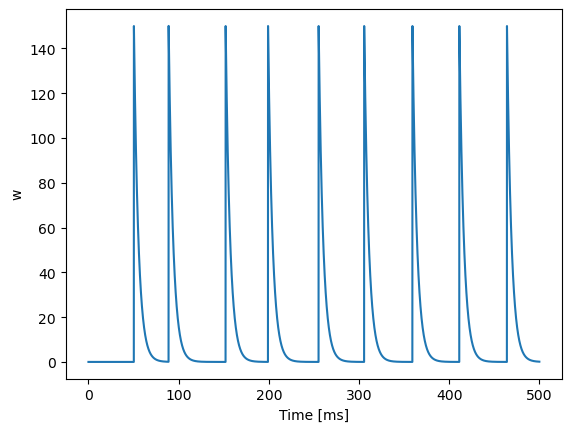

Spike times: [ 48.3  86.8 150.  197.  253.1 303.6 357.1 409.1 461.9] ms


In [3]:
"""
Start with the izhikevich model

AUTAPSE implemented with Synapse class

"""

start_scope()

RS = {'name': 'RS', 'C': 100, 'k': 0.7, 'v_r': -60, 'v_t': -40, 'v_peak': 35,
     'a': 0.03, 'b': -2, 'c': -50, 'd': 100, 'e_a': 0.2, 'f': 150., 'tau': 2.0}    # Class 1

C = RS['C']
k = RS['k']
v_r = RS['v_r']
v_t = RS['v_t']
a = RS['a']
b = RS['b']
c = RS['c']
d = RS['d']
v_peak = RS['v_peak']
# autapse
e_a = RS['e_a']
f = RS['f']
tau = RS['tau']*ms

## The autapse could be implemented through a time-delayed synapse, or somehow the reset can be delayed manually...
eqs = f'''
dv/dt = ((1/C)*(k *(v-v_r)*(v-v_t) - u + w + I))/ms : 1
du/dt = (a * (b*(v-v_r) - u))/ms : 1
dw/dt = (-e_a*w)/ms : 1
C : 1
k : 1
v_r : 1
v_t : 1
I : 1
a : 1
b : 1
c : 1
d : 1
f : 1
e_a : 1
tau : 1
'''


reset = '''
v = c
u += d
'''

G = NeuronGroup(1, eqs, threshold= 'v>=v_peak', reset = reset, method = 'euler')
M_v = StateMonitor(G, 'v', record = 0)
M_u = StateMonitor(G, 'u', record = 0)
M_w = StateMonitor(G, 'w', record = 0)
spikemon = SpikeMonitor(G, record = True)

# Synapses
autapse = '''
dw/dt = (-e_a*w)/ms : 1
f : 1
e_a : 1
tau : 1
'''
aut = Synapses(G, G,  
             on_pre='''
             w += f
             ''')
aut.connect(condition = 'i == j')
aut.delay = tau


# Intialise variables
G.v = -60
G.C = C
G.k = k
G.v_r = v_r
G.v_t = v_t
G.a = a
G.b = b
G.I = 100        # the driving current is static in this case
G.c = c
G.d = d
G.e_a = e_a
G.f = f


duration = 500*ms
run(duration)


plot(M_v.t/ms, M_v.v[0])
xlabel('Time [ms]')
ylabel('v')
show()

plot(M_u.t/ms, M_u.u[0])
xlabel('Time [ms]')
ylabel('u')
show()

plot(M_w.t/ms, M_w.w[0])
xlabel('Time [ms]')
ylabel('w')
show()

print(f"Spike times: {spikemon.t[:]}")



#### Try with multiple neurons...

WARNING    The object 'neurongroup' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File 'C:\Users\liamm\AppData\Local\Temp\ipykernel_47956\155854565.py', line 53, in <module>
    G = NeuronGroup(N_neurons, eqs, threshold= 'v>=v_peak', reset = reset, method = 'rk2') [brian2.core.base.unused_brian_object]
WARNING    The object 'synapses' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File 'C:\Users\liamm\AppData\Local\Temp\ipykernel_47956\155854565.py', line 59, in <module>
    aut = Synapses(G, G, [brian2.core.base.unused_brian_object]
WARNING    'C' is an internal variable of group 'ne

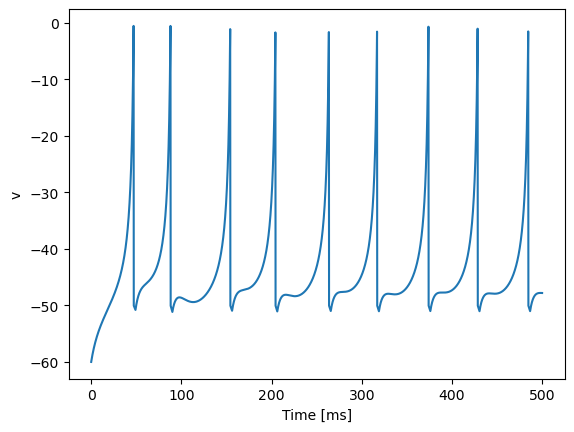

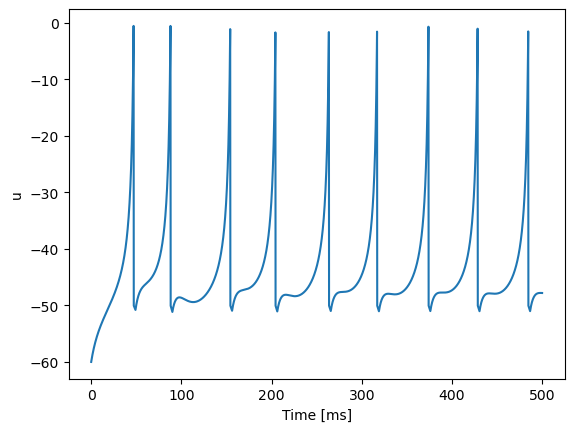

Spike times: [ 47.   47.   47.   47.   47.   47.   47.   47.   47.   47.   87.9  87.9
  87.9  87.9  87.9  87.9  87.9  87.9  87.9  87.9 154.1 154.1 154.1 154.1
 154.1 154.1 154.1 154.1 154.1 154.1 204.2 204.2 204.2 204.2 204.2 204.2
 204.2 204.2 204.2 204.2 263.5 263.5 263.5 263.5 263.5 263.5 263.5 263.5
 263.5 263.5 316.9 316.9 316.9 316.9 316.9 316.9 316.9 316.9 316.9 316.9
 373.9 373.9 373.9 373.9 373.9 373.9 373.9 373.9 373.9 373.9 428.4 428.4
 428.4 428.4 428.4 428.4 428.4 428.4 428.4 428.4 484.5 484.5 484.5 484.5
 484.5 484.5 484.5 484.5 484.5 484.5] ms


In [4]:
"""
Start with the izhikevich model

AUTAPSE implemented with Synapse class

"""

start_scope()

N_neurons = 10

RS = {'name': 'RS', 'C': 100, 'k': 0.7, 'v_r': -60, 'v_t': -40, 'v_peak': 35,
     'a': 0.03, 'b': -2, 'c': -50, 'd': 100, 'e_a': 0.2, 'f': 150., 'tau': 2.0}    # Class 1

C = np.array([RS['C'] for _ in range(N_neurons)])
k = np.array([RS['k'] for _ in range(N_neurons)])
v_r = np.array([RS['v_r'] for _ in range(N_neurons)])
v_t = np.array([RS['v_t'] for _ in range(N_neurons)])
a = np.array([RS['a'] for _ in range(N_neurons)])
b = np.array([RS['b'] for _ in range(N_neurons)])
c = np.array([RS['c'] for _ in range(N_neurons)])
d = np.array([RS['d'] for _ in range(N_neurons)])
v_peak = np.array([RS['v_peak'] for _ in range(N_neurons)])
# autapse
e_a = np.array([RS['e_a'] for _ in range(N_neurons)])
f = np.array([RS['f'] for _ in range(N_neurons)])
tau = np.array([RS['tau'] for _ in range(N_neurons)])*ms

## The autapse could be implemented through a time-delayed synapse, or somehow the reset can be delayed manually...
eqs = f'''
dv/dt = ((1/C)*(k *(v-v_r)*(v-v_t) - u + w + I))/ms : 1
du/dt = (a * (b*(v-v_r) - u))/ms : 1
dw/dt = (-e_a*w)/ms : 1
C : 1
k : 1
v_r : 1
v_t : 1
I : 1
a : 1
b : 1
c : 1
d : 1
f : 1
e_a : 1
v_peak : 1
'''

reset = '''
v = c
u += d
'''

G = NeuronGroup(N_neurons, eqs, threshold= 'v>=v_peak', reset = reset, method = 'rk2')
M_v = StateMonitor(G, 'v', record = 0)
M_v2 = StateMonitor(G, 'v', record = 5)
spikemon = SpikeMonitor(G, record = True)

# Synapses
aut = Synapses(G, G,  
             on_pre='''
             w += f
             ''')
aut.connect(condition = 'i == j')
aut.delay = tau


# Initialise variables
G.v = np.array([-60 for _ in range(N_neurons)])
G.u = np.array([0. for _ in range(N_neurons)])
G.w = np.array([0. for _ in range(N_neurons)])
G.C = C
G.k = k
G.v_r = v_r
G.v_t = v_t
G.a = a
G.b = b
G.I = np.array([100 for _ in range(N_neurons)])        # the driving current is static in this case
G.c = c
G.d = d
G.e_a = e_a
G.f = f


duration = 500*ms
run(duration)


plot(M_v.t/ms, M_v.v[0])
xlabel('Time [ms]')
ylabel('v')
show()

plot(M_v2.t/ms, M_v2.v[0])
xlabel('Time [ms]')
ylabel('u')
show()

print(f"Spike times: {spikemon.t[:]}")



#### Try running things with the new class

In [2]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')



100%|██████████| 49999/49999 [00:07<00:00, 6834.73it/s]


<class 'numpy.float64'>
<class 'numpy.float64'>
[ True False False False False False False False False False False False
 False False False False False False False False]
[0.00000000e+00 1.75000281e-09 3.49266571e-09 5.22803134e-09
 6.95612812e-09 8.67699157e-09 1.03906501e-08 1.20971464e-08
 1.37965088e-08 1.54887658e-08 1.71739529e-08 1.88521057e-08
 2.05232595e-08 2.21874430e-08 2.38446844e-08 2.54950194e-08
 2.71384764e-08 2.87750908e-08 3.04048982e-08 3.20279199e-08]
batchAQUA spikes
[[ 48.19  86.51 149.92 196.94 253.43 303.66 357.77 409.34 462.57]
 [ 48.19  86.51 149.92 196.94 253.43 303.66 357.77 409.34 462.57]
 [ 48.19  86.51 149.92 196.94 253.43 303.66 357.77 409.34 462.57]
 [ 48.19  86.51 149.92 196.94 253.43 303.66 357.77 409.34 462.57]
 [ 48.19  86.51 149.92 196.94 253.43 303.66 357.77 409.34 462.57]
 [ 48.19  86.51 149.92 196.94 253.43 303.66 357.77 409.34 462.57]
 [ 48.19  86.51 149.92 196.94 253.43 303.66 357.77 409.34 462.57]
 [ 48.19  86.51 149.92 196.94 253.43 303.66 

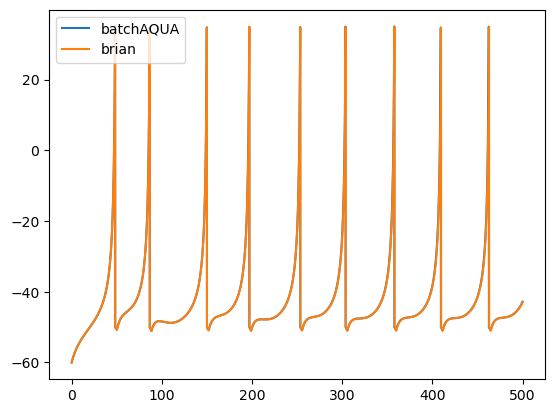

In [ ]:
start_scope()


N_neurons = 10

RS = {'name': 'RS', 'C': 100, 'k': 0.7, 'v_r': -60, 'v_t': -40, 'v_peak': 35,
     'a': 0.03, 'b': -2, 'c': -50, 'd': 100, 'e': 0.2, 'f': 150., 'tau': 2.0}    # Class 1

T = 500 # ms
dt = 0.01
N_iter = int(T/dt)

params = []
x_start = np.zeros((N_neurons, 3))
t_start = np.zeros(N_neurons)
I_inj = 100.*np.ones((N_neurons, N_iter))
for i in range(N_neurons):
    params.append(RS)
    x_start[i] = np.array([-60., 0., 0.])

param_df = pd.DataFrame(params)

batch = batchAQUA(param_df)
batch.Initialise(x_start, t_start)


G, autapses = batch.meetBrian()
G.I = I_inj[:, 0]
# simulation timestep
defaultclock.dt = dt*ms
M_v = StateMonitor(G, 'v', record = 0)
spikemon = SpikeMonitor(G, record = True)
net = Network(G, autapses, M_v, spikemon)
plt.show()

# Run both simulations
net.run(T*ms)

X, time, spikes = batch.update_batch(dt, N_iter, I_inj)

plt.plot(time, X[0, 0], label = 'batchAQUA')
plt.plot(M_v.t/ms, M_v.v[0], label = "brian")
plt.legend()


print(type(X[0, 0, 0]))
print(type(M_v.v[0][0]))

print(X[0, 0, :20] == M_v.v[0][:20])
print(X[0, 0, :20] - M_v.v[0][:20])

print("batchAQUA spikes")
print(spikes[0])

print("Brian spikes")
print(spikemon.t[:].reshape((N_neurons, -1), order = 'F')[0])

